# EDA. Trenowanie modelu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, load_model, predict_model
from pathlib import Path
import os # Nadal potrzebne dla os.path.abspath(__file__)
from dotenv import load_dotenv
import boto3
import io
import pickle

## 1. Nawiązywanie połączenia z Digital Ocean Spaces i pobieranie danych

In [2]:
s3 = boto3.client(
    "s3",
    # aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    # aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    # Endpoint jest potrzebny dlatego że używamy chmury innej niż AWS 
    # endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 
    # Gdybyśmy używali AWS to musielibyśmy natomiast podać region
    #region_name='eu-central-1'
)

In [3]:
BUCKET_NAME = "civil-eng"

In [4]:
# Wczytujemy dane z półmaratonu osobno dla każdego roku z Cloud Storage do DataFrame

df_2023 = pd.read_csv(f"s3://{BUCKET_NAME}/RunModel/Dane/halfmarathon_wroclaw_2023__final.csv", sep=';')
df_2024 = pd.read_csv(f"s3://{BUCKET_NAME}/RunModel/Dane/halfmarathon_wroclaw_2024__final.csv", sep=';')

## 2. EDA

### 2.1 Pierwsze zapoznanie się z danymi. Pierwszy krok transformacji

In [5]:
df_2023.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [6]:
df_2024.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,596,NIKODEM,DWORCZAK,KOŚCIAN,POL,NaN,M,1.0,M20,...,2.920000,00:45:07,2.0,3.083333,01:00:33,1.0,3.086667,0.007267,01:04:03,3.036265
1,2.0,616,MATEUSZ,KACZOR,RADOM,POL,RLTL OPTIMA RADOM,M,2.0,M20,...,2.920000,00:45:07,3.0,3.083333,01:00:38,2.0,3.103333,0.008267,01:04:24,3.052856
2,3.0,154,PATRYK,KOZŁOWSKI,RADOM,POL,RLTL-ZTE-RADOM,M,3.0,M20,...,2.920000,00:45:07,1.0,3.083333,01:00:59,3.0,3.173333,0.012467,01:04:40,3.065497
3,4.0,591,DARIUSZ,BORATYŃSKI,WROCŁAW,POL,WOSIEK TEAM AZS AWF WROCŁAW,M,4.0,M20,...,3.110000,00:47:48,4.0,3.293333,01:05:40,4.0,3.573333,0.028667,01:09:44,3.305681
4,5.0,521,SZYMON,DOROŻYŃSKI,LUBON,POL,SZYMI TEAM AZS POLITECHNIKA OPOLSKA,M,5.0,M30,...,3.153333,00:48:09,5.0,3.453333,01:06:05,5.0,3.586667,0.039800,01:10:05,3.322272


In [7]:
# Dodajemy kolumne Wiek
df_2023['Wiek']=2023-df_2023['Rocznik']
df_2024['Wiek']=2024-df_2024['Rocznik']
# Połączenie plików w jeden
df = pd.concat([df_2023, df_2024], ignore_index=True)

In [8]:
df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,31.0
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,37.0
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,27.0
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,35.0
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,28.0


In [9]:
# Zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [10]:
for col in df:
    if 'Czas' in col:
        df[col] = df[col].apply(convert_time_to_seconds)

In [11]:
df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2687.0,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509,31.0
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2726.0,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875,37.0
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,2854.0,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475,27.0
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963,35.0
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654,28.0


### 2.2 Podstawowa Charakterystyka DataFrame df

In [12]:
# 1. Podaj wymiary zbioru danych (liczba wierszy i kolumn)
print(f"\n1. Wymiary zbioru danych: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")


1. Wymiary zbioru danych: 21957 wierszy, 28 kolumn.


In [13]:
# 2. Lista wszystkich kolumn wraz z ich typami danych
print("\n2. Kolumny i ich typy danych:")
print(df.info()) # podsumowanie, w tym typy danych i brakujące wartości


2. Kolumny i ich typy danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  float64
 13  5 km Miejsce Op

In [14]:
# 3. Podsumowanie statystyczne dla wszystkich kolumn numerycznych
print("\n3. Podsumowanie statystyczne dla kolumn numerycznych:")
df.describe() 


3. Podsumowanie statystyczne dla kolumn numerycznych:


,Miejsce,Numer startowy,Płeć Miejsce,Kategoria wiekowa Miejsce,Rocznik,5 km Czas,5 km Miejsce Open,5 km Tempo,10 km Czas,10 km Miejsce Open,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
count,18450.000000,21957.000000,18450.000000,18430.000000,21472.000000,18411.000000,18411.000000,18411.000000,18427.000000,18427.000000,...,18428.000000,18428.000000,18413.000000,18439.000000,18439.000000,18422.000000,18377.000000,18450.000000,18450.000000,21472.000000
mean,4675.680325,9131.001685,2741.137615,734.757352,1981.449935,1675.902069,4684.677638,5.586340,3346.535519,4681.817984,...,5116.353375,4677.332103,5.900787,7019.431097,4676.539997,6.342749,0.052152,7407.961084,5.852857,42.142604
std,2768.846110,14449.830643,1913.875736,590.148277,76.047837,247.635360,2776.085712,0.825451,510.663514,2772.998560,...,804.302812,2768.849902,1.012626,1145.972606,2769.430762,1.222979,0.047737,1217.213325,0.961692,76.046683
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1755.000000,1.000000,...,2687.000000,1.000000,3.083333,3633.000000,1.000000,3.086667,-0.345333,3843.000000,3.036265,17.000000
25%,2307.000000,2994.000000,1154.000000,251.000000,1978.000000,1505.000000,2311.500000,5.016667,2988.000000,2309.000000,...,4551.000000,2309.000000,5.193333,6216.000000,2308.000000,5.490000,0.020533,6555.000000,5.178952,32.000000
50%,4613.000000,5847.000000,2307.000000,589.000000,1985.000000,1663.000000,4619.000000,5.543333,3312.000000,4617.000000,...,5047.000000,4613.500000,5.766667,6885.000000,4614.000000,6.140000,0.041867,7256.000000,5.732796,39.000000
75%,6919.000000,8771.000000,4227.750000,1071.750000,1992.000000,1837.500000,6927.000000,6.125000,3669.000000,6927.000000,...,5615.000000,6920.250000,6.503333,7719.000000,6919.500000,7.020000,0.073333,8153.750000,6.442087,46.000000
max,10302.000000,86990.000000,7240.000000,2388.000000,2006.000000,3825.000000,10353.000000,12.750000,6208.000000,10330.000000,...,9249.000000,10305.000000,11.213333,12082.000000,10306.000000,14.940000,0.629533,12754.000000,10.076637,2024.000000


In [15]:
# 4. Podsumowanie dla kolumn kategorycznych
print("\n4. Podsumowanie dla kolumn kategorycznych:")
categorical_cols = df.select_dtypes(include='object').columns.tolist() # Wybieramy kolumny typu 'object' (zazwyczaj kategoryczne)
# Możesz również dodać kolumny typu 'category' jeśli takie masz w DataFrame
categorical_cols.extend(df.select_dtypes(include='category').columns.tolist())
categorical_cols = list(categorical_cols) 

if categorical_cols:
    for col in categorical_cols:
        print(f"\n--- Kolumna kategoryczna: '{col}' ---")
        print(f"Liczba unikalnych wartości: {df[col].nunique()}")
        most_common_value = df[col].mode()[0] # mode() zwraca serię, więc bierzemy pierwszy element
        most_common_frequency = df[col].value_counts().max()
        missing_values_count = df[col].isnull().sum()
        missing_percentage = (df[col].isnull().sum() / len(df[col])) * 100
        duplicate_rows = df[df[col].duplicated()]

        
        print(f"Najczęstsza wartość: '{most_common_value}'")
        print(f"Częstość najczęstszej wartości: {most_common_frequency}")
        print(f"Liczba brakujących wartości: {missing_values_count}")
        print(f"Procent brakujących wartości w kolumnie: {missing_percentage:.2f}%")
        # Opcjonalnie: wyświetl wszystkie unikalne wartości i ich częstości
        #print("Wszystkie unikalne wartości i ich częstości:")
        #print(df[col].value_counts())
else:
    print("Brak kolumn kategorycznych (typu 'object' lub 'category') w zbiorze danych.")


4. Podsumowanie dla kolumn kategorycznych:

--- Kolumna kategoryczna: 'Imię' ---
Liczba unikalnych wartości: 975
Najczęstsza wartość: 'TOMASZ'
Częstość najczęstszej wartości: 795
Liczba brakujących wartości: 0
Procent brakujących wartości w kolumnie: 0.00%

--- Kolumna kategoryczna: 'Nazwisko' ---
Liczba unikalnych wartości: 10274
Najczęstsza wartość: 'ZAWODNIK'
Częstość najczęstszej wartości: 699
Liczba brakujących wartości: 0
Procent brakujących wartości w kolumnie: 0.00%

--- Kolumna kategoryczna: 'Miasto' ---
Liczba unikalnych wartości: 2170
Najczęstsza wartość: 'WROCŁAW'
Częstość najczęstszej wartości: 5997
Liczba brakujących wartości: 4183
Procent brakujących wartości w kolumnie: 19.05%

--- Kolumna kategoryczna: 'Kraj' ---
Liczba unikalnych wartości: 43
Najczęstsza wartość: 'POL'
Częstość najczęstszej wartości: 18038
Liczba brakujących wartości: 3507
Procent brakujących wartości w kolumnie: 15.97%

--- Kolumna kategoryczna: 'Drużyna' ---
Liczba unikalnych wartości: 4035
Najczęs

### 2.3 Identyfikacja Problemów Jakościowych w df


1. Procent brakujących danych w każdej kolumnie:
Drużyna                      61.734299
Miasto                       19.050872
Tempo Stabilność             16.304595
10 km Tempo                  16.222617
5 km Miejsce Open            16.149747
5 km Czas                    16.149747
5 km Tempo                   16.149747
15 km Tempo                  16.140639
20 km Tempo                  16.099649
10 km Czas                   16.076878
10 km Miejsce Open           16.076878
15 km Czas                   16.072323
15 km Miejsce Open           16.072323
Kategoria wiekowa Miejsce    16.063214
20 km Miejsce Open           16.022225
20 km Czas                   16.022225
Czas                         15.972127
Tempo                        15.972127
Miejsce                      15.972127
Płeć Miejsce                 15.972127
Kraj                         15.972127
Rocznik                       2.208863
Wiek                          2.208863
Kategoria wiekowa             0.141185
Płeć          

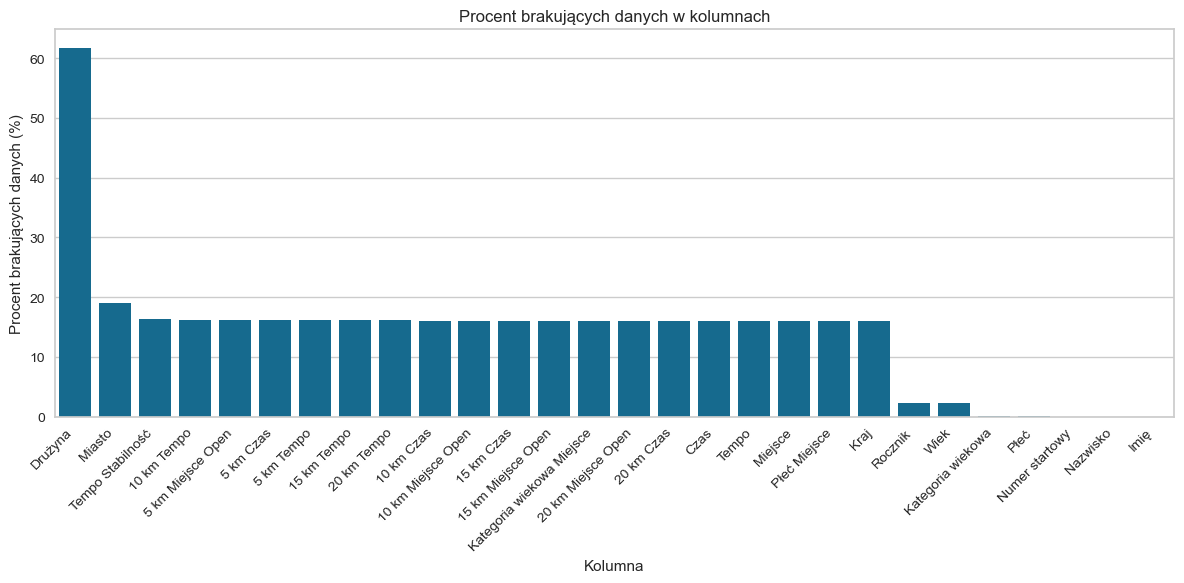

In [16]:
# 1. Wizualizacja procentowa brakujących danych dla każdej kolumny. Sortowanie wyniki malejąco.
print("\n1. Procent brakujących danych w każdej kolumnie:")
missing_percentages = df.isnull().sum() / len(df) * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

print(missing_percentages)

# Wizualizacja
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentages.index, y=missing_percentages)
plt.xticks(rotation=45, ha='right')
plt.title('Procent brakujących danych w kolumnach')
plt.ylabel('Procent brakujących danych (%)')
plt.xlabel('Kolumna')
plt.tight_layout()
plt.show()

In [17]:
# 2. Identyfikacja kolumn, które mają tylko jedną unikalną wartość (stałe). Są one bezużyteczne dla modelu.
print("\n2. Kolumny z tylko jedną unikalną wartością (stałe):")
constant_columns = []
for col in df.columns:
    if df[col].nunique(dropna=False) == 1: # dropna=False wlicza NaN jako unikalną wartość, jeśli jest jedyną
        constant_columns.append(col)

if constant_columns:
    print("Następujące kolumny mają tylko jedną unikalną wartość i są bezużyteczne dla modelu:")
    for col in constant_columns:
        print(f"- {col} (Wartość: {df[col].iloc[0]})")
else:
    print("Brak kolumn z tylko jedną unikalną wartością.")


2. Kolumny z tylko jedną unikalną wartością (stałe):
Brak kolumn z tylko jedną unikalną wartością.


In [18]:
# 3. Sprawdzenie, czy istnieją w pełni zduplikowane wiersze w zbiorze danych. Podaj ich liczbę.
print("\n3. Sprawdzenie w pełni zduplikowanych wierszy:")
duplicate_rows_count = df.duplicated().sum()

if duplicate_rows_count > 0:
    print(f"Znaleziono {duplicate_rows_count} w pełni zduplikowanych wierszy.")
    print("Przykładowe zduplikowane wiersze (pierwsze wystąpienie jest pominięte):")
    print(df[df.duplicated(keep='first')])
else:
    print("Brak w pełni zduplikowanych wierszy w zbiorze danych.")


3. Sprawdzenie w pełni zduplikowanych wierszy:
Brak w pełni zduplikowanych wierszy w zbiorze danych.


In [19]:
# 4. Analiza kardynalności (liczby unikalnych wartości) w kolumnach kategorycznych. Zidentyfikuj te o bardzo wysokiej kardynalności.
print("\n4. Analiza kardynalności w kolumnach kategorycznych:")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_cols:
    cardinality_threshold = 0.5 # Próg, np. 50% unikalnych wartości w stosunku do liczby wierszy
    high_cardinality_columns = []

    for col in categorical_cols:
        num_unique = df[col].nunique(dropna=True) # Pomiń NaN
        total_rows = len(df)
        cardinality_ratio = num_unique / total_rows

        print(f"- Kolumna '{col}': {num_unique} unikalnych wartości (Część zbioru: {cardinality_ratio:.2%})")

        if cardinality_ratio > cardinality_threshold:
            high_cardinality_columns.append(col)

    if high_cardinality_columns:
        print("\nKolumny o bardzo wysokiej kardynalności (powyżej 50% unikalnych wartości):")
        for col in high_cardinality_columns:
            print(f"- {col}")
        print("Kolumny o wysokiej kardynalności często wymagają specjalnego traktowania (np. grupowanie, target encoding) lub mogą być zbędne.")
    else:
        print("Brak kolumn kategorycznych o bardzo wysokiej kardynalności (powyżej zdefiniowanego progu - 50%).")
else:
    print("Brak kolumn kategorycznych (typu 'object' lub 'category') w zbiorze danych.")


4. Analiza kardynalności w kolumnach kategorycznych:
- Kolumna 'Imię': 975 unikalnych wartości (Część zbioru: 4.44%)
- Kolumna 'Nazwisko': 10274 unikalnych wartości (Część zbioru: 46.79%)
- Kolumna 'Miasto': 2170 unikalnych wartości (Część zbioru: 9.88%)
- Kolumna 'Kraj': 43 unikalnych wartości (Część zbioru: 0.20%)
- Kolumna 'Drużyna': 4035 unikalnych wartości (Część zbioru: 18.38%)
- Kolumna 'Płeć': 2 unikalnych wartości (Część zbioru: 0.01%)
- Kolumna 'Kategoria wiekowa': 13 unikalnych wartości (Część zbioru: 0.06%)
Brak kolumn kategorycznych o bardzo wysokiej kardynalności (powyżej zdefiniowanego progu - 50%).


In [20]:
# 5. Filtrujemy wiersze, gdzie kolumna "Czas" ma brakujące wartości
df_czas_nan = df[df['Czas'].isna()].copy()

list_of_combinations = []

if df_czas_nan.empty:
    print("Brak wierszy z brakującymi wartościami w kolumnie 'Czas'. Brak kombinacji do wyświetlenia.")
else:
    # Określamy brakujące wartości dla pozostałych kolumn w tych wierszach
    nan_mask = df_czas_nan.isna()
    nan_mask_other_cols = nan_mask.drop(columns=['Czas'])
    nan_pattern = nan_mask_other_cols.astype(int) # Konwertujemy True/False na 1/0

    # Funkcja do generowania wzorca dla pojedynczego wiersza
    def generate_pattern_and_count(row):
        parts = []
        nan_count_in_row = 0
        for col in nan_pattern.columns:
            if row[col] == 1: # Jeśli jest NaN w danej kolumnie
                parts.append(f"{col}:NaN")
                nan_count_in_row += 1
        
        pattern_str = ", ".join(parts) if parts else "Tylko Czas:NaN"
        return pattern_str, nan_count_in_row

    # Aplikujemy funkcję, aby uzyskać wzorzec i liczbę kolumn dla każdego wiersza
    # `.apply` z `result_type='expand'` pozwala zwrócić wiele kolumn
    df_czas_nan[['Combinations', 'Num_Other_NaN_Cols']] = nan_pattern.apply(
        generate_pattern_and_count, axis=1, result_type='expand'
    )

    # Zliczamy wystąpienia każdej unikalnej kombinacji
    # Musimy grupować po obu kolumnach 'Combinations' i 'Num_Other_NaN_Cols'
    combination_counts_with_cols = df_czas_nan.groupby(['Combinations', 'Num_Other_NaN_Cols']).size().reset_index(name='Ilość Wystąpień')

    # Sortujemy dla lepszej czytelności, np. malejąco po ilości wystąpień
    combination_counts_with_cols = combination_counts_with_cols.sort_values(by='Ilość Wystąpień', ascending=False)

    # Tworzymy finalną listę pythonową
    for index, row in combination_counts_with_cols.iterrows():
        list_of_combinations.append({
            'kombinacja': row['Combinations'],
            'ilosc_kolumn_z_NaN': row['Num_Other_NaN_Cols'],
            'ilosc_wystapien': row['Ilość Wystąpień']
        })

    print("Lista kombinacji brakujących wartości (gdy 'Czas' jest NaN) z liczbą dodatkowych kolumn z NaN:\n")
    for item in list_of_combinations:
        print(item)

Lista kombinacji brakujących wartości (gdy 'Czas' jest NaN) z liczbą dodatkowych kolumn z NaN:

{'kombinacja': 'Miejsce:NaN, Miasto:NaN, Kraj:NaN, Drużyna:NaN, Płeć Miejsce:NaN, Kategoria wiekowa Miejsce:NaN, 5 km Czas:NaN, 5 km Miejsce Open:NaN, 5 km Tempo:NaN, 10 km Czas:NaN, 10 km Miejsce Open:NaN, 10 km Tempo:NaN, 15 km Czas:NaN, 15 km Miejsce Open:NaN, 15 km Tempo:NaN, 20 km Czas:NaN, 20 km Miejsce Open:NaN, 20 km Tempo:NaN, Tempo Stabilność:NaN, Tempo:NaN', 'ilosc_kolumn_z_NaN': 20, 'ilosc_wystapien': 2242}
{'kombinacja': 'Miejsce:NaN, Miasto:NaN, Kraj:NaN, Płeć Miejsce:NaN, Kategoria wiekowa Miejsce:NaN, 5 km Czas:NaN, 5 km Miejsce Open:NaN, 5 km Tempo:NaN, 10 km Czas:NaN, 10 km Miejsce Open:NaN, 10 km Tempo:NaN, 15 km Czas:NaN, 15 km Miejsce Open:NaN, 15 km Tempo:NaN, 20 km Czas:NaN, 20 km Miejsce Open:NaN, 20 km Tempo:NaN, Tempo Stabilność:NaN, Tempo:NaN', 'ilosc_kolumn_z_NaN': 19, 'ilosc_wystapien': 1254}
{'kombinacja': 'Miejsce:NaN, Miasto:NaN, Kraj:NaN, Drużyna:NaN, Płeć:Na

In [21]:
# 6. Sprawdzenie czy usunięcie wierszy NaN kolumny "czas" jest racjonalne
# Wiersze, gdzie 'Czas' ma brakujące wartości (NaN)
rows_where_czas_is_nan = df[df['Czas'].isna()]

# Sprawdzenie, które kolumny w tych wierszach (poza 'Czas') nie mają brakujących wartości
non_missing_columns_when_czas_is_nan = []

if rows_where_czas_is_nan.empty:
    print("Brak wierszy, w których kolumna 'Czas' ma brakujące wartości.")
else:
    # Iteruj przez wszystkie kolumny oprócz 'Czas'
    for col in df.columns:
        if col == 'Czas':
            continue # Pomiń kolumnę 'Czas'

        # Sprawdzenie, czy w tych wierszach (gdzie 'Czas' jest NaN), bieżąca kolumna ma wszystkie wartości (nie-NaN)
        # `.notna().all()` zwróci True, jeśli WSZYSTKIE wartości w danej kolumnie (w przefiltrowanym widoku) są nie-NaN
        if rows_where_czas_is_nan[col].notna().all():
            non_missing_columns_when_czas_is_nan.append(col)

    if non_missing_columns_when_czas_is_nan:
        print("Kolumny mające nie-brakujące wartości, gdy kolumna 'Czas' ma brakujące wartości:")
        for col_name in non_missing_columns_when_czas_is_nan:
            print(f"- {col_name}")
        print("Jeśli kolumny powyżej nie mają znaczenia wiersze NaN kolumny Czas można usunąć")
    else:
        print("Brak kolumn, które miałyby pełne wartości w wierszach, gdzie 'Czas' ma braki.")

Kolumny mające nie-brakujące wartości, gdy kolumna 'Czas' ma brakujące wartości:
- Numer startowy
- Imię
- Nazwisko
- Rocznik
- Wiek
Jeśli kolumny powyżej nie mają znaczenia wiersze NaN kolumny Czas można usunąć


### 2.4 Faza 2: Czyszczenie Danych (Data Cleaning)

In [22]:
print(f"\n Wymiary zbioru danych przed usunięciem wierszy z brakami w kolumnie 'Czas': \n {df.shape[0]} wierszy, {df.shape[1]} kolumn.")

# Usuwanie wierszy, które mają NaN w kolumnie 'Czas'
# 'subset' pozwala określić, które kolumny mają być sprawdzane pod kątem NaN
# 'inplace=True' modyfikuje DataFrame bezpośrednio
df.dropna(subset=['Czas'], inplace=True)

print(f"\n Wymiary zbioru danych po usunięciu wierszy z brakami w kolumnie 'Czas': \n {df.shape[0]} wierszy, {df.shape[1]} kolumn.")


 Wymiary zbioru danych przed usunięciem wierszy z brakami w kolumnie 'Czas': 
 21957 wierszy, 28 kolumn.

 Wymiary zbioru danych po usunięciu wierszy z brakami w kolumnie 'Czas': 
 18450 wierszy, 28 kolumn.


#### Redukcja Dataframe do kolumn "Wiek", "Płeć", "5 km Czas",  "Czas"

In [23]:
print("DataFrame przed transformacją:")
print(f"\n Wymiary zbioru danych: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")
columns=["Wiek", "Płeć", "5 km Czas", "Czas"]
print(f"\n Kolumny do zachowania: {columns}")
df=df[columns]
print("DataFrame po transformacji:")
print(df.head())
print(f"\n Wymiary zbioru danych: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")


DataFrame przed transformacją:

 Wymiary zbioru danych: 18450 wierszy, 28 kolumn.

 Kolumny do zachowania: ['Wiek', 'Płeć', '5 km Czas', 'Czas']
DataFrame po transformacji:
   Wiek Płeć  5 km Czas    Czas
0  31.0    M      877.0  3899.0
1  37.0    M      888.0  3983.0
2  27.0    M      946.0  4104.0
3  35.0    M      971.0  4216.0
4  28.0    M      972.0  4227.0

 Wymiary zbioru danych: 18450 wierszy, 4 kolumn.


#### Eliminacja wartości odstających

In [24]:
# Iterujemy przez każdą kolumnę i usuwamy z niej wartości odstające
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtrowanie wartości odstających dla bieżącej kolumny
        # Zmieniamy przypisanie df w każdej iteracji, aby filtrować na podstawie skumulowanych warunków
        # Oznacza to, że jeśli wiersz jest odstający w którejkolwiek z kolumn, zostanie usunięty
        df = df[~((df[column] < lower_bound) | (df[column] > upper_bound))]


In [25]:
print(f"\n Wymiary zbioru danych po usunięciu wartości odstających: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")


 Wymiary zbioru danych po usunięciu wartości odstających: 17973 wierszy, 4 kolumn.


In [26]:
# Podsumowanie statystyczne dla wszystkich kolumn numerycznych
df.describe()

,Wiek,5 km Czas,Czas
count,17500.000000,17936.000000,17973.000000
mean,38.889029,1665.662299,7350.560841
std,9.768058,233.078436,1137.392640
min,17.000000,1005.000000,4248.000000
25%,31.000000,1501.000000,6543.000000
50%,39.000000,1657.000000,7227.000000
75%,45.000000,1825.000000,8088.000000
max,67.000000,2328.000000,10471.000000


### 2.5 Wizualna Eksploracja

In [27]:
# 1. Podaj wymiary zbioru danych (liczba wierszy i kolumn)
print(f"\n1. Wymiary zbioru danych: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")


1. Wymiary zbioru danych: 17973 wierszy, 4 kolumn.


In [28]:
# 2. Lista wszystkich kolumn wraz z ich typami danych
print("\n2. Kolumny i ich typy danych:")
print(df.info()) # podsumowanie, w tym typy danych i brakujące wartości


2. Kolumny i ich typy danych:
<class 'pandas.core.frame.DataFrame'>
Index: 17973 entries, 8 to 19089
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Wiek       17500 non-null  float64
 1   Płeć       17973 non-null  object 
 2   5 km Czas  17936 non-null  float64
 3   Czas       17973 non-null  float64
dtypes: float64(3), object(1)
memory usage: 702.1+ KB
None


In [29]:
# 3. Podsumowanie statystyczne dla wszystkich kolumn numerycznych
print("\n3. Podsumowanie statystyczne dla kolumn numerycznych:")
df.describe() 


3. Podsumowanie statystyczne dla kolumn numerycznych:


,Wiek,5 km Czas,Czas
count,17500.000000,17936.000000,17973.000000
mean,38.889029,1665.662299,7350.560841
std,9.768058,233.078436,1137.392640
min,17.000000,1005.000000,4248.000000
25%,31.000000,1501.000000,6543.000000
50%,39.000000,1657.000000,7227.000000
75%,45.000000,1825.000000,8088.000000
max,67.000000,2328.000000,10471.000000


In [30]:
# 4. Podsumowanie dla kolumn kategorycznych
print("\n4. Podsumowanie dla kolumn kategorycznych:")
categorical_cols = df.select_dtypes(include='object').columns.tolist() # Wybieramy kolumny typu 'object' (zazwyczaj kategoryczne)
# Możesz również dodać kolumny typu 'category' jeśli takie masz w DataFrame
categorical_cols.extend(df.select_dtypes(include='category').columns.tolist())
categorical_cols = list(categorical_cols) 

if categorical_cols:
    for col in categorical_cols:
        print(f"\n--- Kolumna kategoryczna: '{col}' ---")
        print(f"Liczba unikalnych wartości: {df[col].nunique()}")
        most_common_value = df[col].mode()[0] # mode() zwraca serię, więc bierzemy pierwszy element
        most_common_frequency = df[col].value_counts().max()
        missing_values_count = df[col].isnull().sum()
        missing_percentage = (df[col].isnull().sum() / len(df[col])) * 100
        duplicate_rows = df[df[col].duplicated()]

        
        print(f"Najczęstsza wartość: '{most_common_value}'")
        print(f"Częstość najczęstszej wartości: {most_common_frequency}")
        print(f"Liczba brakujących wartości: {missing_values_count}")
        print(f"Procent brakujących wartości w kolumnie: {missing_percentage:.2f}%")
        # Opcjonalnie: wyświetl wszystkie unikalne wartości i ich częstości
        #print("Wszystkie unikalne wartości i ich częstości:")
        #print(df[col].value_counts())
else:
    print("Brak kolumn kategorycznych (typu 'object' lub 'category') w zbiorze danych.")


4. Podsumowanie dla kolumn kategorycznych:

--- Kolumna kategoryczna: 'Płeć' ---
Liczba unikalnych wartości: 2
Najczęstsza wartość: 'M'
Częstość najczęstszej wartości: 12763
Liczba brakujących wartości: 0
Procent brakujących wartości w kolumnie: 0.00%



5. Procent brakujących danych w każdej kolumnie:
Wiek         2.631725
5 km Czas    0.205864
Płeć         0.000000
Czas         0.000000
dtype: float64


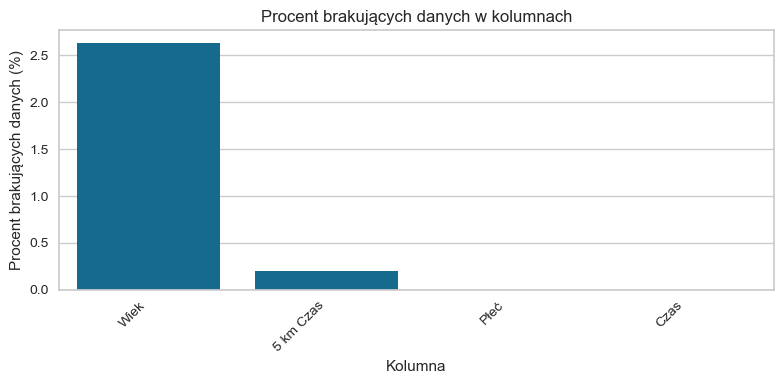

In [31]:
# 5. Wizualizacja procentowa brakujących danych dla każdej kolumny. Sortowanie wyniki malejąco.
print("\n5. Procent brakujących danych w każdej kolumnie:")
missing_percentages = df.isnull().sum() / len(df) * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

print(missing_percentages)

# Wizualizacja
plt.figure(figsize=(8, 4))
sns.barplot(x=missing_percentages.index, y=missing_percentages)
plt.xticks(rotation=45, ha='right')
plt.title('Procent brakujących danych w kolumnach')
plt.ylabel('Procent brakujących danych (%)')
plt.xlabel('Kolumna')
plt.tight_layout()
plt.show()


6. Generowanie histogramów dla zmiennych numerycznych...


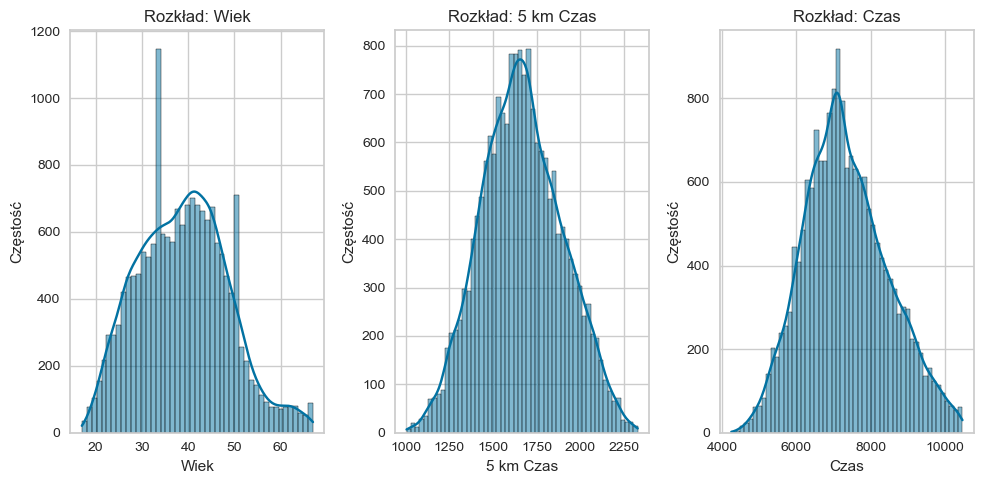

Histogramy wygenerowane.


In [32]:
# 6. Zidentyfikuj zmienne numeryczne
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

if not numeric_cols:
    print("\n6. Brak zmiennych numerycznych do wizualizacji histogramów i boxplotów.")
else:
    # 1. Wygeneruj histogramy dla wszystkich zmiennych numerycznych
    print("\n6. Generowanie histogramów dla zmiennych numerycznych...")
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(numeric_cols):
        plt.subplot(np.ceil(len(numeric_cols)/3).astype(int), 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Rozkład: {col}')
        plt.xlabel(col)
        plt.ylabel('Częstość')
    plt.tight_layout()
    plt.show()
    print("Histogramy wygenerowane.")


7. Generowanie wykresów pudełkowych (boxplotów) dla kluczowych zmiennych numerycznych...


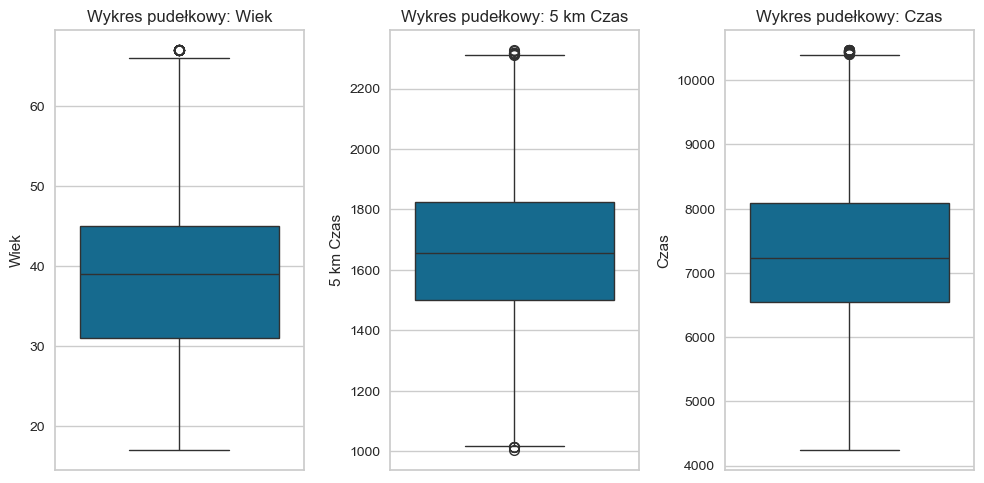

Wykresy pudełkowe wygenerowane.


In [33]:
# 7. Boxploty
if not numeric_cols:
    print("\n7. Brak zmiennych numerycznych do wizualizacji histogramów i boxplotów.")
else:
    # 2. Wykresy pudełkowe (boxplots) dla kluczowych zmiennych numerycznych
    # Tutaj możesz wybrać te zmienne, które Cię najbardziej interesują.
    # Na potrzeby przykładu wezmę wszystkie numeryczne.
    print("\n7. Generowanie wykresów pudełkowych (boxplotów) dla kluczowych zmiennych numerycznych...")

    # Możesz zdefiniować swoje "kluczowe zmienne" tutaj:
    # key_numeric_vars = ['num_var1', 'num_var3', 'num_var4']
    key_numeric_vars = numeric_cols # W przykładzie użyjemy wszystkich numerycznych

    if not key_numeric_vars:
        print("Brak kluczowych zmiennych numerycznych do wykresów pudełkowych.")
    else:
        plt.figure(figsize=(10, 5))
        for i, col in enumerate(key_numeric_vars):
            plt.subplot(np.ceil(len(key_numeric_vars)/3).astype(int), 3, i + 1)
            sns.boxplot(y=df[col])
            plt.title(f'Wykres pudełkowy: {col}')
            plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        print("Wykresy pudełkowe wygenerowane.")


8. Generowanie macierzy korelacji (heatmap) dla zmiennych numerycznych...


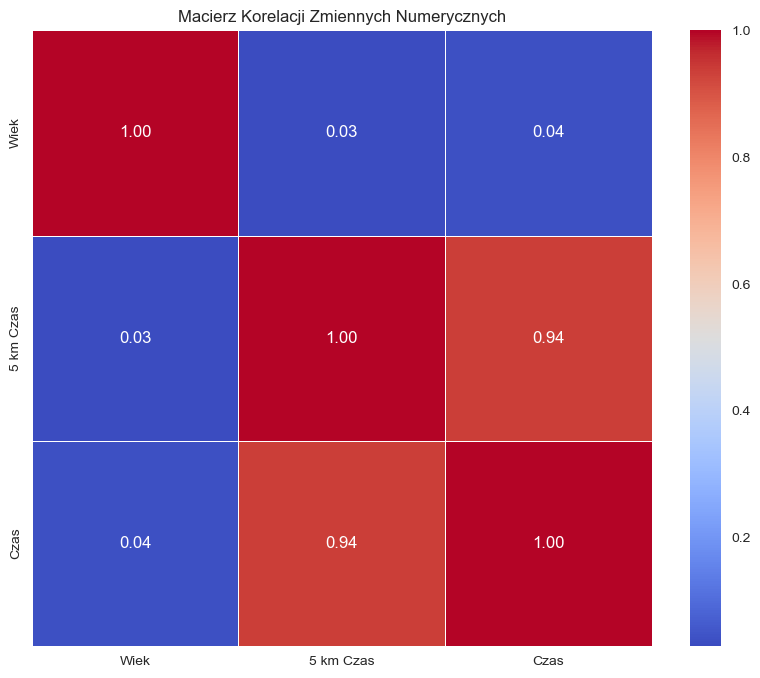

Macierz korelacji wygenerowana.

   Identyfikacja silnie skorelowanych cech (abs(korelacja) > 0.7):
Pary silnie skorelowanych cech:
- (Czas, 5 km Czas): Korelacja = 0.94


In [34]:
# 8. Macierz korelacji
if not numeric_cols:
    print("Brak zmiennych numerycznych do analizy korelacji.")
else:
    # 3. Wygeneruj macierz korelacji (heatmap) dla zmiennych numerycznych
    print("\n8. Generowanie macierzy korelacji (heatmap) dla zmiennych numerycznych...")
    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Macierz Korelacji Zmiennych Numerycznych')
    plt.show()
    print("Macierz korelacji wygenerowana.")

    # Identyfikacja silnie skorelowanych cech
    print("\n   Identyfikacja silnie skorelowanych cech (abs(korelacja) > 0.7):")
    # Tworzymy maskę na górną trójkątną część macierzy, żeby nie wyświetlać duplikatów i korelacji z samym sobą
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    strong_correlations = upper_tri.unstack().sort_values(ascending=False).drop_duplicates()

    # Filtrujemy tylko te z silną korelacją (np. > 0.7 lub < -0.7)
    strong_correlations = strong_correlations[(strong_correlations.abs() > 0.7)]
    if not strong_correlations.empty:
        print("Pary silnie skorelowanych cech:")
        for (col1, col2), corr_val in strong_correlations.items():
            print(f"- ({col1}, {col2}): Korelacja = {corr_val:.2f}")
    else:
        print("Brak par silnie skorelowanych cech (powyżej progu 0.7) w zbiorze danych.")



9. Generowanie wykresów relacji zmiennej 'Czas' z wybranymi cechami...


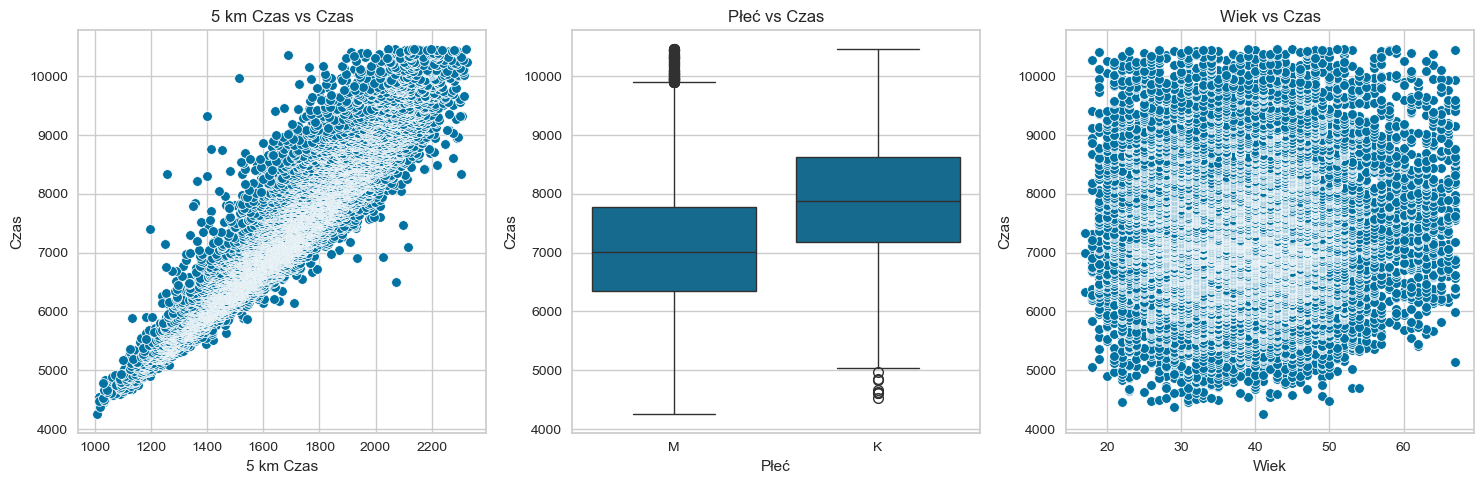

Wykresy relacji wygenerowane.


In [35]:
# 9. Wykresy dla zmiennej docelowej pokazujące jej relację z najważniejszymi cechami.

# 'top_features' lista nazw najważniejszych cech, które chcesz przeanalizować.
target_variable_name = 'Czas' # <--- ZMIENNA DOCELOWA
top_features = ['5 km Czas', 'Płeć','Wiek'] # Dane
#top_features = [col for col in df.columns if col != target_variable_name][:10] # Bierzemy pierwsze 10 cech innych niż zmienna docelowa jako przykład

if target_variable_name not in df.columns:
    print(f"\nBłąd: Kolumna '{target_variable_name}' nie istnieje w DataFrame. Proszę poprawić nazwę zmiennej docelowej.")
elif not top_features:
    print("\nBrak zdefiniowanych 'najważniejszych' cech do wizualizacji z zmienną docelową.")
else:
    print(f"\n9. Generowanie wykresów relacji zmiennej '{target_variable_name}' z wybranymi cechami...")
    # Dynamiczne tworzenie wykresów w zależności od typu cechy
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(top_features):
        plt.subplot(np.ceil(len(top_features)/3).astype(int), 3, i + 1)

        if pd.api.types.is_numeric_dtype(df[feature]):
            # Scatter plot dla zmiennych numerycznych vs numeryczna/binarna zmienna docelowa
            sns.scatterplot(x=df[feature], y=df[target_variable_name])
            plt.title(f'{feature} vs {target_variable_name}')
        elif pd.api.types.is_categorical_dtype(df[feature]) or pd.api.types.is_object_dtype(df[feature]):
            # Boxplot lub barplot dla zmiennych kategorycznych vs numeryczna/binarna zmienna docelowa
            if pd.api.types.is_numeric_dtype(df[target_variable_name]):
                sns.boxplot(x=df[feature], y=df[target_variable_name])
                plt.title(f'{feature} vs {target_variable_name}')
            else: # Jeśli zmienna docelowa jest kategoryczna
                sns.countplot(x=df[feature], hue=df[target_variable_name])
                plt.title(f'{feature} rozkład dla {target_variable_name}')
                plt.xticks(rotation=45, ha='right') # Obróć etykiety dla czytelności
        else:
            print(f"Brak obsługiwanego typu wykresu dla cechy '{feature}' (typ: {df[feature].dtype}) vs zmienna docelowa.")
            plt.close() # Zamknij nieużywany subplot
            continue # Przejdź do następnej cechy
        plt.tight_layout()
    plt.tight_layout()
    plt.show()
    print("Wykresy relacji wygenerowane.")

## 3. Rezultat - dataframe po oczyszczeniu


In [36]:
# Ścieżka do pliku w DigitalOcean Spaces
file_path_in_spaces = "RunModel/Dane/halfmarathon_wroclaw_2023_2024__final.csv"

In [37]:
# Zapis DataFrame do bufora bajtowego (bezpośrednio w pamięci)
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)

In [38]:
# Upewnij się, że wskaźnik bufora jest na początku przed odczytem
csv_buffer.seek(0)

0

In [39]:
# Upload bufora do DigitalOcean Spaces
try:
    s3.put_object(
        Bucket=BUCKET_NAME,
        Key=file_path_in_spaces,
        Body=csv_buffer.getvalue(),
        ContentType='text/csv' # Opcjonalne: typ zawartości
    )
    print(f"DataFrame został pomyślnie zapisany do DigitalOcean Spaces pod ścieżką: {file_path_in_spaces}")
except Exception as e:
    print(f"Wystąpił błąd podczas zapisu do DigitalOcean Spaces: {e}")

DataFrame został pomyślnie zapisany do DigitalOcean Spaces pod ścieżką: RunModel/Dane/halfmarathon_wroclaw_2023_2024__final.csv


In [40]:
# Zapis dataframe po transformacjach do pliku csv lokalnie
df.to_csv('Dane\halfmarathon_wroclaw_2023_2024__final.csv',  sep=';',index=False)

In [41]:
len(df)

17973

In [42]:
print("\n1. 10 losowych wierszy zbioru danych:")
df.sample(10)


1. 10 losowych wierszy zbioru danych:


,Wiek,Płeć,5 km Czas,Czas
11096,49.0,K,1529.0,6462.0
17247,51.0,K,1998.0,8469.0
7777,36.0,M,2131.0,9621.0
14612,34.0,M,1698.0,7489.0
6194,47.0,M,1761.0,8120.0
11252,49.0,M,1451.0,6515.0
17375,28.0,K,1830.0,8533.0
17702,48.0,K,1988.0,8726.0
7908,67.0,M,2064.0,9933.0
11311,57.0,M,1441.0,6537.0


## 4. Trenowanie modelu

### 4.1 Setup

In [43]:
exp = setup(data=df, target="Czas", numeric_features=["Wiek", "5 km Czas"], session_id=123)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17973, 4)"
4,Transformed data shape,"(17973, 4)"
5,Transformed train set shape,"(12581, 4)"
6,Transformed test set shape,"(5392, 4)"
7,Numeric features,2
8,Categorical features,1
9,Rows with missing values,2.8%


### 4.2 Compare Models

In [44]:
best_model_1 = exp.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,294.8158,162803.2647,403.2556,0.8745,0.0520,0.0389,0.0450
lr,Linear Regression,295.3437,163039.9116,403.5631,0.8743,0.0521,0.0390,0.3040
lasso,Lasso Regression,295.3297,163021.4554,403.5396,0.8743,0.0521,0.0390,0.2370
ridge,Ridge Regression,295.3437,163039.8963,403.5630,0.8743,0.0521,0.0390,0.2380
en,Elastic Net,295.3270,163017.9122,403.5352,0.8743,0.0521,0.0390,0.2090
lar,Least Angle Regression,295.3437,163039.9116,403.5631,0.8743,0.0521,0.0390,0.0070
llar,Lasso Least Angle Regression,295.3297,163021.4551,403.5396,0.8743,0.0521,0.0390,0.0060
br,Bayesian Ridge,295.3249,163015.6554,403.5324,0.8743,0.0521,0.0390,0.0060
omp,Orthogonal Matching Pursuit,295.5084,163220.5188,403.7964,0.8741,0.0521,0.0390,0.0070
huber,Huber Regressor,291.8107,166151.3400,407.3497,0.8719,0.0523,0.0383,0.0120


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

### 4.3 Evaluate Models

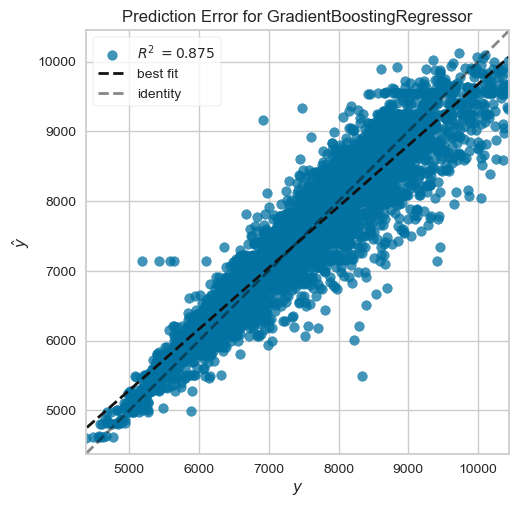

In [45]:
plot_model(best_model_1, plot='error')

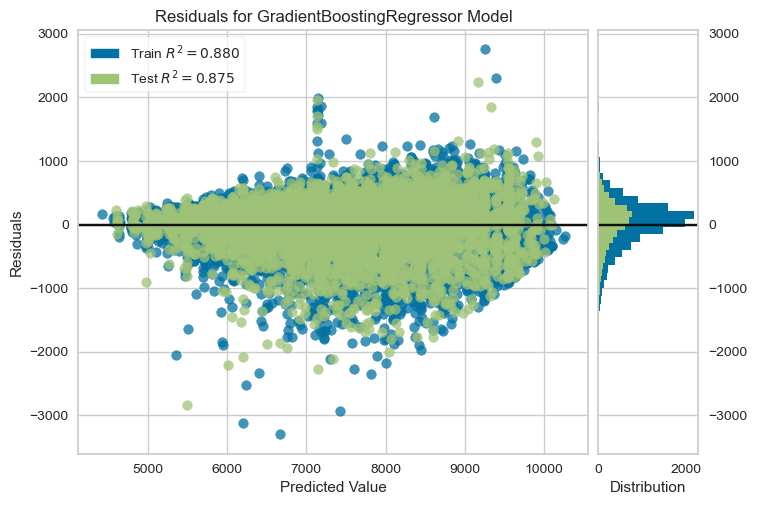

In [46]:
plot_model(best_model_1, plot='residuals')

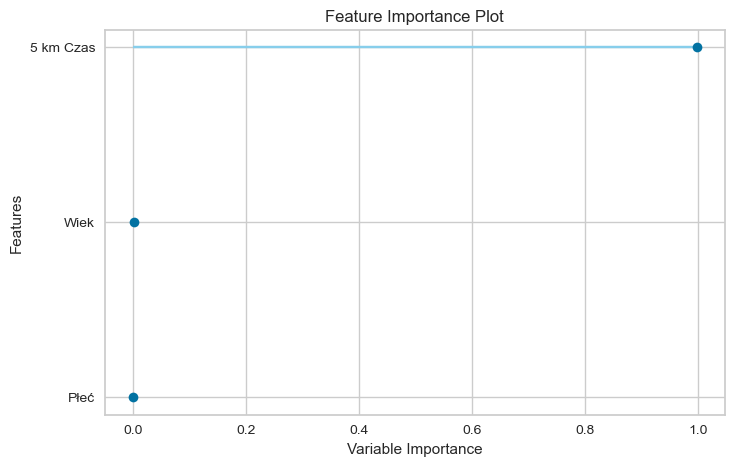

In [47]:
plot_model(best_model_1, plot='feature')

### 4.4 Model tuning

In [48]:
tuned_best_model_1 = exp.tune_model(best_model_1, n_iter=50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,294.9527,161187.2460,401.4813,0.8816,0.0518,0.0392
1,287.8886,151108.9310,388.7273,0.8777,0.0503,0.0382
2,295.2520,160538.7739,400.6729,0.8695,0.0517,0.0390
3,295.1572,164075.6366,405.0625,0.8636,0.0528,0.0393
4,293.1690,164593.7085,405.7015,0.8784,0.0527,0.0390
5,285.0640,147536.9767,384.1054,0.8837,0.0501,0.0379
6,308.8084,182429.4064,427.1176,0.8646,0.0542,0.0402
7,301.7377,175864.3023,419.3618,0.8670,0.0541,0.0398
8,309.4045,175633.3153,419.0863,0.8656,0.0543,0.0407


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [49]:
best_model = exp.compare_models([best_model_1, tuned_best_model_1])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,294.8158,162803.2647,403.2556,0.8745,0.0520,0.0389,0.0450
1,Gradient Boosting Regressor,294.8158,162803.2647,403.2556,0.8745,0.0520,0.0389,0.0460


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

In [50]:
exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,293.7886,160571.4477,400.7137,0.8747,0.0517,0.0388


,Wiek,Płeć,5 km Czas,Czas,prediction_label
11382,50.0,M,1579.0,6556.0,6945.885766
16507,30.0,K,1873.0,8139.0,8335.199629
12313,26.0,M,NaN,6860.0,7135.611345
16495,42.0,K,1862.0,8132.0,8204.434767
18499,58.0,M,2076.0,9358.0,9464.104610
...,...,...,...,...,...
11789,55.0,M,1498.0,6695.0,6576.151502
14802,47.0,M,1669.0,7545.0,7357.080475
14440,31.0,M,1581.0,7424.0,6931.067152
7706,31.0,K,2192.0,9495.0,9631.485321


### 4.5 Finalize Model and Save

In [51]:
final_model = exp.finalize_model(best_model)
# Zapis modelu lokalnie
exp.save_model(final_model, 'Model\\runtime_regression_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
          

#### Zapis do Degital ocean spaces

In [52]:
# Ścieżka do pliku w DigitalOcean Spaces
Model_pkl_in_spaces = "RunModel/Model/runtime_regression_pipeline.pkl"

In [53]:
# Serializacja modelu do bufora bajtowego (bezpośrednio w pamięci)
model_buffer = io.BytesIO()
pickle.dump(final_model, model_buffer)

# Upewnij się, że wskaźnik bufora jest na początku przed odczytem
model_buffer.seek(0)

# Upload bufora do DigitalOcean Spaces
try:
    s3.put_object(
        Bucket=BUCKET_NAME,
        Key=Model_pkl_in_spaces ,
        Body=model_buffer.getvalue(),
        ContentType='application/octet-stream' # Standardowy typ dla plików binarnych
    )
    print(f"Model został pomyślnie zapisany do DigitalOcean Spaces pod ścieżką: {Model_pkl_in_spaces}")
except Exception as e:
    print(f"Wystąpił błąd podczas zapisu modelu do DigitalOcean Spaces: {e}")

Model został pomyślnie zapisany do DigitalOcean Spaces pod ścieżką: RunModel/Model/runtime_regression_pipeline.pkl
